# Detecting loadwords with Keras

### In this notebook you will:
1. Train a neural network using Keras.
1. Optimize hyperparameters for the Neural Net.
1. Record model training statistics for viewing with tensor board.
1. Save the best model using checkpoints. 
1. Compare the performance between the Neural Net and the Decision Tree classifier.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import logging
import random
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import density
from cltk.stem.latin.j_v import JVReplacer
from cltk.prosody.latin.scansion_constants import ScansionConstants
from cltk.prosody.latin.string_utils import remove_punctuation_dict
from cltk.tokenize.word import WordTokenizer
from cltk.corpus.readers import get_corpus_reader
from cltk.utils.featurization import word_to_features
from cltk.utils.file_operations import md5

plt.style.use('fivethirtyeight')


Using TensorFlow backend.


## Fix random seed values for reproducibility and tuning
see: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

In [3]:
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### Add parent directory to path so we can access our common code

In [4]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [5]:
from mlyoucanuse.featurize_text_fun import word_to_features

### Turn on logging, primarily so that library methods may report warnings, if any

In [6]:
LOG = logging.getLogger('make_model')
LOG.addHandler(logging.NullHandler())
logging.basicConfig(level=logging.INFO)
tf.logging.set_verbosity(tf.logging.ERROR) # silence a deprecation warning; todo revisit

## Load the saved X,y matrix 
as created in the `detect_loanwords_problems_solutions` notebook

In [41]:
all_X = None
with open('all_X.pkl', 'rb') as pickle_file:
    all_X = pickle.load(pickle_file)
all_y = None
with open('all_y', 'rb') as pickle_file:
    all_y = pickle.load(pickle_file)
all_X.astype(np.float32)
all_y.astype(np.float32)

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

## Process the saved matrix

In [42]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.3, random_state=42)
# Partition equal sizes of test and validation sets
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [43]:
scaler = StandardScaler()
# try:  all_X.astype(np.float64)
# Fit scaler only on training slice of data; 
# As with all the transformations, it is important to fit the scalers to the training data only,
# not to the full dataset (including the test set).
scaler.fit(X_train.astype(np.float32))
# TODO pickle this scaler for applying the same transforms to input
with open('scaler.pkl', 'wb') as fwriter:
    pickle.dump(scaler, fwriter)    
# Fit all 3 data sets
X_train = scaler.transform(X_train.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))
X_validation = scaler.transform(X_validation.astype(np.float32))

## Create Keras callbacks for Checkpointing, Tensor board, and Early Stopping
Early stopping is promising, but it did not work as well as expected for this data set. Elsewhere and with large batches, it can be invaluable.

In [44]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=0,
                               mode='auto',
                               baseline=None,
                               restore_best_weights=False)
tensor_board = TensorBoard(log_dir='./logs',
                           histogram_freq=0,
                           batch_size=32,
                           write_graph=True,
                           write_grads=False,
                           write_images=False,
                           embeddings_freq=0,
                           embeddings_layer_names=None,
                           embeddings_metadata=None,
                           embeddings_data=None,
                           update_freq='epoch')
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, tensor_board]

## Create a function to plot the history of the model training and validation

In [45]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend()

# Create Keras Model

In [46]:
num_features = all_X.shape[1]   

model = Sequential()
model.add(Dense(500, input_dim=num_features, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# you could preload training weights, but this could bias your search
# if os.path.exists('weights.best.hdf5'):
#     model.load_weights('weights.best.hdf5')

model.compile(loss='binary_crossentropy', 
              optimizer=
#  'nadam',                            
# 'sgd' ,               
# 'adadelta',
 'adam',
              metrics=['accuracy'])
# also tried:
#  optimizer='rmsprop' 
# activation='elu'
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 500)               13000     
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 501       
Total params: 264,001
Trainable params: 264,001
Non-trainable params: 0
_________________________________________________________________


In [47]:
 history = model.fit(X_train, y_train,
                     epochs=20,
                     verbose=True,
                     validation_data=(X_test, y_test),
                     batch_size=32,
                     callbacks=callbacks_list)

Train on 158620 samples, validate on 33990 samples
Epoch 1/20
158620/158620 [==============================] - 21s 131us/step - loss: 0.4067 - acc: 0.8271 - val_loss: 0.3620 - val_acc: 0.8417

Epoch 00001: val_acc improved from -inf to 0.84175, saving model to weights.best.hdf5
Epoch 2/20
158620/158620 [==============================] - 21s 130us/step - loss: 0.3169 - acc: 0.8651 - val_loss: 0.2748 - val_acc: 0.8835

Epoch 00002: val_acc improved from 0.84175 to 0.88352, saving model to weights.best.hdf5
Epoch 3/20
158620/158620 [==============================] - 21s 131us/step - loss: 0.2624 - acc: 0.8893 - val_loss: 0.2479 - val_acc: 0.8976

Epoch 00003: val_acc improved from 0.88352 to 0.89765, saving model to weights.best.hdf5
Epoch 4/20
158620/158620 [==============================] - 20s 128us/step - loss: 0.2398 - acc: 0.8997 - val_loss: 0.2479 - val_acc: 0.8917

Epoch 00004: val_acc did not improve from 0.89765
Epoch 5/20
158620/158620 [==============================] - 20s 128

In [48]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print(f"Training Accuracy: {accuracy:.4f} Loss: {loss:.4f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f"Testing Accuracy: {accuracy:.4f} Loss: {loss:.4f}")
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=True)
print(f"Unseen Accuracy: {accuracy:.4f} Loss: {loss:.4f}")

158620/158620 [==============================] - 4s 27us/step
Training Accuracy: 0.9332 Loss: 0.1632
33990/33990 [==============================] - 1s 27us/step
Testing Accuracy: 0.9250 Loss: 0.1843
33991/33991 [==============================] - 1s 27us/step
Unseen Accuracy: 0.9243 Loss: 0.1831


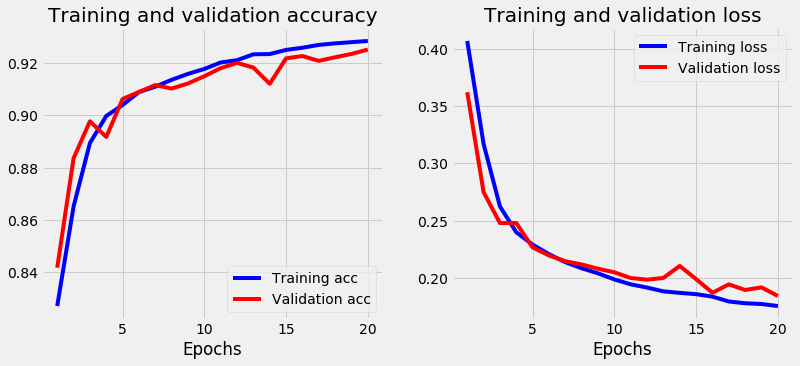

In [49]:
plot_history(history)

## Results of parameter tuning
### 1 Layer
* 800 units, 1 layer, 20 epochs
    * Training Accuracy: 0.8638
    * Testing Accuracy: 0.8606
### 2 Layers
* 800 units, 2 layers, 15 epochs: 92%
    * Training Accuracy: 0.9192 
    * Testing Accuracy: 0.9124
* 1000 units, 25 epochs: 
    * Training Accuracy: 0.9318
    * Testing Accuracy: 0.9251
* 100->50 units, 25 epochs, stopped at:
* 48*25 = 1200 units, 25 epochs using elu
    * Training Accuracy: 0.9055
    * Testing Accuracy: 0.9031
* 1200 units
    * Training Accuracy: 0.9322
    * Testing Accuracy: 0.9253
* 900 units
    * Training Accuracy: 0.9322
    * Testing Accuracy: 0.9242
* 800 units
    * Training Accuracy: 0.9329
    * Testing Accuracy: 0.9266
* 200 units
    * Training Accuracy: 0.9284
    * Testing Accuracy: 0.9217
* 400 units
    * Training Accuracy: 0.9305
    * Testing Accuracy: 0.9227
* 600 units
    * Training Accuracy: 0.9332
    * Testing Accuracy: 0.9272
* 500 units using nadam:
    * Training Accuracy: 0.9164
    * Testing Accuracy: 0.9117
* 500 units using adam, batch 16:
    * Training Accuracy: 0.9279 Loss: 0.1768
    * Testing Accuracy: 0.9204 Loss: 0.2025
    * Unseen Accuracy: 0.9226 Loss: 0.1937
* 500 units, adam, batch 8:
    * Training Accuracy: 0.9257 Loss: 0.2001
    * Testing Accuracy: 0.9204 Loss: 0.2224
    * Unseen Accuracy: 0.9210 Loss: 0.2146
* 500 units, adam, batch: 32
    * Training Accuracy: 0.9305 Loss: 0.1685
    * Testing Accuracy: 0.9222 Loss: 0.1918
    * Unseen Accuracy: 0.9235 Loss: 0.1904
* Same as above using 32 bit floats:
    * Training Accuracy: 0.9332 Loss: 0.1632
    * Testing Accuracy: 0.9250 Loss: 0.1843
    * Unseen Accuracy: 0.9243 Loss: 0.1831

## Tips for parameter tuning
* Set a seed for random on the Python and library levels, as done early in this notebook
* Be sure to recreate and compile your model fresh with each training session;
    * If you rerun the .fit() method, you’ll start off with the computed weights from the previous training.
* Study the history plots of each run, notice where training and validation characteristically starts to diverge more and more.
    * Your training and validation graphs may have local minima, so you might not be able to use early stopping automatically.


## Fit final model

In [35]:
all_X_scaled = scaler.fit_transform(all_X.astype(np.float32))
model = Sequential()
model.add(Dense(500, input_dim=num_features, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', 
              optimizer='adam')
model.fit(all_X_scaled, all_y,
                     epochs=18,
                     verbose=False,                     
                     batch_size=32)
model.save('loanword_detector.greek_latin.keras.h5')

## Load the model and call it a run time (don't use pickle)

In [36]:
mymodel = load_model('loanword_detector.greek_latin.keras.h5')

In [37]:
def is_greek(word):
    x = [word_to_features(word, max_word_length=25)]
    # Use the fitted transformer, load from a pickle if necessary
    x=np.array(x).astype(np.float32)
    x = scaler.transform(x) 
    return mymodel.predict(x)

In [38]:
is_greek('arxomai') 

array([[0.9515998]], dtype=float32)

In [39]:
is_greek('veritas')

array([[0.12234748]], dtype=float32)

In [40]:
is_greek('thuon')

array([[0.99567956]], dtype=float32)

## Comparing the scikit learn classifier vs. the Keras Neural Net
* RandomForest Classifier
    * 1.3 Gigabytes pickle size
    * accuracy: 96%
* Keras Neural Net
    * 4.3 Megabytes h5 size
    * accuracy: 92.88%

These results are typical for a relatively small dataset. Decision tree classifiers do very well, but can be prone to overfitting; and on the downside, the decision tree model is somewhat large. The neural net is small and is not overfitting. It is more compact and quite performant, and should a worthwhile consideration.

Both models might benefit from training with more data, and this is an area for future investigation.

# That's all for now folks!